 <p style="font-size:36px;text-align:center"> <b>MOS Prediction</b> </p>

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

Source: https://www.kaggle.com/valeriol93/predict-qoe

Problem Statement: The scope is to predict a level of "Quality of Experience" (e.g. Mean Opinion Score - MOS) with other measured KPIs (classification task). 

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

Dataset: https://www.kaggle.com/valeriol93/predict-qoe

We have one data file. Dataset has 105828 unique records with 9 features.

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

There are five different classes  => <b> Multi class</b> classification problem

<h3>2.2.2. Performance Metric</h3>

The dataset is imbalance and Accuracy would not be a good performance matrix to use. As you mentioned in email accuracy of 70% is achievable but model is not performing well on minority classes. So instead of Accuracy I chose F1 score, precision, recall, confusion matrix as a performnce matrix.

<h1>3. Exploratory Data Analysis and Data Cleaning</h1>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
#import mpl_scatter_density
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib
matplotlib.use('nbagg')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
from sklearn.metrics import accuracy_score,classification_report,auc,f1_score,roc_auc_score,roc_curve, confusion_matrix,log_loss
from sklearn.preprocessing import StandardScaler,MinMaxScaler


from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import class_weight
from catboost import CatBoostClassifier,Pool
from imblearn.over_sampling import SMOTE

from sklearn import decomposition
pca = decomposition.PCA()

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import pairwise_distances


C:\Users\JAYESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  # Remove the CWD from sys.path while we load stuff.


<h2>3.1 Data Reading</h2>

In [2]:
df = pd.read_excel('dataset.xlsx')

In [3]:
df.columns = ['Date','Signal','Speed','Distance','Duration','Result','Type','Time','MOS']
df.dtypes

Date        datetime64[ns]
Signal             float64
Speed              float64
Distance           float64
Duration           float64
Result              object
Type                object
Time               float64
MOS                float64
dtype: object

In [4]:
df.head()

,Date,Signal,Speed,Distance,Duration,Result,Type,Time,MOS
0,2017-07-01 00:00:27,-61.0,68.800003,1048.60,90.0,SUCCESS,UMTS,0.56,2.1
1,2017-07-01 00:02:57,-61.0,68.769997,1855.54,90.0,SUCCESS,UMTS,0.45,3.2
2,2017-07-01 00:05:29,-71.0,69.169998,1685.62,90.0,SUCCESS,UMTS,0.51,2.1
3,2017-07-01 00:08:02,-65.0,69.279999,1770.92,90.0,SUCCESS,UMTS,0.00,1.0
4,2017-07-01 00:10:30,-103.0,0.820000,256.07,60.0,SUCCESS,UMTS,3.35,3.6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105828 entries, 0 to 105827
Data columns (total 9 columns):
Date        105828 non-null datetime64[ns]
Signal      105821 non-null float64
Speed       105828 non-null float64
Distance    95469 non-null float64
Duration    105828 non-null float64
Result      105828 non-null object
Type        105828 non-null object
Time        105828 non-null float64
MOS         105828 non-null float64
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 7.3+ MB


<b>Signal</b> and <b>Distance</b> have null values. Let's impute them using median values.

In [6]:
df['Distance'].fillna(df['Distance'].median(),inplace=True)
df['Signal'].fillna(df['Signal'].median(),inplace=True)
#df.fillna(0,inplace=True)

In [11]:
df['MOS'].value_counts()

4.4    31011
2.7    16228
1.0    15167
4.3    12528
2.1    12346
3.2     3221
3.3     1158
4.2     1078
2.6     1069
2.2      893
2.3      828
2.4      705
2.0      665
4.1      645
3.7      613
2.5      599
4.0      559
3.1      545
3.4      525
3.8      443
1.9      431
3.6      399
1.1      390
1.8      381
3.0      376
3.9      372
2.9      351
1.7      333
2.8      331
1.6      325
1.5      295
1.2      293
3.5      268
1.4      229
1.3      228
Name: MOS, dtype: int64

Let's convert traget MOS into integer values

In [7]:
for th in [1.0, 2.0, 3.0, 4.0, 5.0]:
     df.loc[(df['MOS']>th - 1)&(df['MOS']<=th),'MOS'] = th

In [16]:
df['MOS'].value_counts()

5.0    45262
3.0    33726
1.0    15167
4.0     8103
2.0     3570
Name: MOS, dtype: int64

In [14]:
target_disb = df['MOS'].value_counts().sortlevel()

In [17]:
#Percentage of each class
sorted_yi = np.argsort(-target_disb.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',target_disb.values[i], '(', np.round((target_disb.values[i]/df.shape[0]*100), 3), '%)')


Number of data points in class 5 : 45262 ( 42.769 %)
Number of data points in class 3 : 33726 ( 31.869 %)
Number of data points in class 1 : 15167 ( 14.332 %)
Number of data points in class 4 : 8103 ( 7.657 %)
Number of data points in class 2 : 3570 ( 3.373 %)


### Observation: Above is the percentage of each class. indicates a imbalanced dataset. Class 5 and class3 covers 73% of data. If our model only predicts class 5 and 3 as output we can achieve 73% Accuracy.

In [37]:
Analyse_df =df.copy()

### Distance Feature

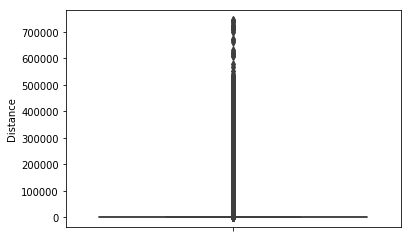

In [31]:
sns.boxplot(y="Distance", data =Analyse_df)
plt.show()

In [32]:
for i in range(0,100,10):
    var =Analyse_df["Distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 1.41
10 percentile value is 150.76
20 percentile value is 216.68
30 percentile value is 286.32
40 percentile value is 383.77
50 percentile value is 430.35
60 percentile value is 503.93
70 percentile value is 613.71
80 percentile value is 877.58
90 percentile value is 1635.85
100 percentile value is  745483.68


In [33]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =Analyse_df["Distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 1635.85
91 percentile value is 1897.24
92 percentile value is 2238.53
93 percentile value is 2652.42
94 percentile value is 3361.25
95 percentile value is 4569.92
96 percentile value is 8216.71
97 percentile value is 19262.83
98 percentile value is 61985.04
99 percentile value is 302597.61
100 percentile value is  745483.68


#### Observation
Seems like 99th and 100th percentile is outliers. Let's just skip it for time being and let it be confimed by Domain Expert.

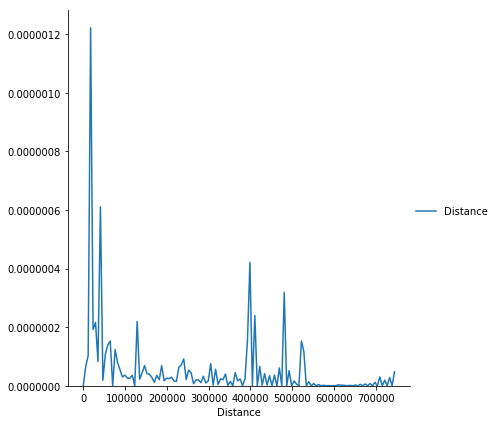

In [34]:
sns.FacetGrid(Analyse_df,size=6) \
      .map(sns.kdeplot,"Distance") \
      .add_legend();
plt.show();

In [38]:
#converting the values to log-values to chec for log-normal
import math
Analyse_df['log_Distance']=[math.log(i) for i in Analyse_df['Distance'].values]

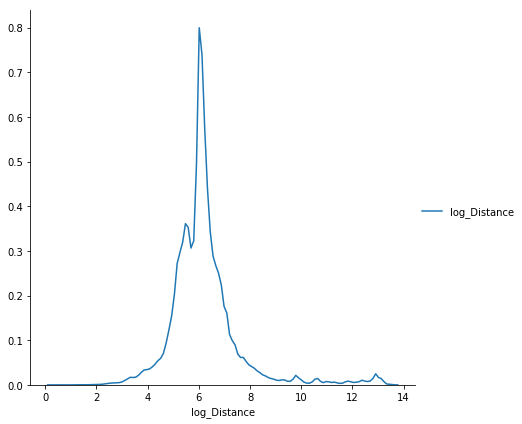

In [39]:
sns.FacetGrid(Analyse_df,size=6) \
      .map(sns.kdeplot,"log_Distance") \
      .add_legend();
plt.show();

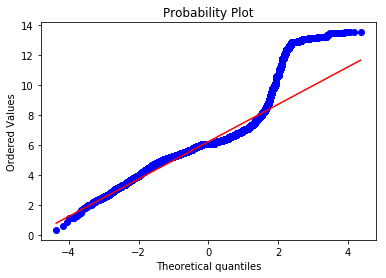

In [41]:
#Q-Q plot for checking if distance is log-normal
import scipy
scipy.stats.probplot(Analyse_df['log_Distance'].values, plot=plt)
plt.show()

### Time

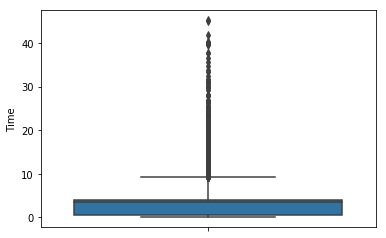

In [42]:
sns.boxplot(y="Time", data =df)
plt.show()

In [43]:
for i in range(0,100,10):
    var =Analyse_df["Time"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.38
20 percentile value is 0.57
30 percentile value is 0.72
40 percentile value is 1.22
50 percentile value is 3.51
60 percentile value is 3.75
70 percentile value is 3.96
80 percentile value is 4.2
90 percentile value is 4.55
100 percentile value is  45.33


In [44]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =Analyse_df["Time"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 4.55
91 percentile value is 4.61
92 percentile value is 4.67
93 percentile value is 4.73
94 percentile value is 4.83
95 percentile value is 4.95
96 percentile value is 5.11
97 percentile value is 5.36
98 percentile value is 5.85
99 percentile value is 6.8
100 percentile value is  45.33


In [45]:
for i in np.arange(0.0, 1.0, 0.1):
    var = Analyse_df["Time"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 6.8
99.1 percentile value is 6.96
99.2 percentile value is 7.19
99.3 percentile value is 7.5
99.4 percentile value is 7.87
99.5 percentile value is 8.41
99.6 percentile value is 9.1
99.7 percentile value is 10.18
99.8 percentile value is 12.52
99.9 percentile value is 17.61
100 percentile value is  45.33


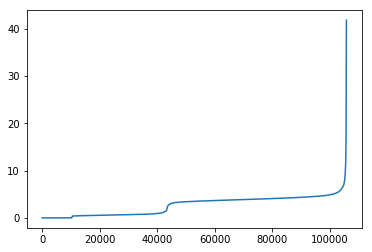

In [46]:
plt.plot(var[:-2])
plt.show()

##### OBSERVATION: Not sure outlier present or not

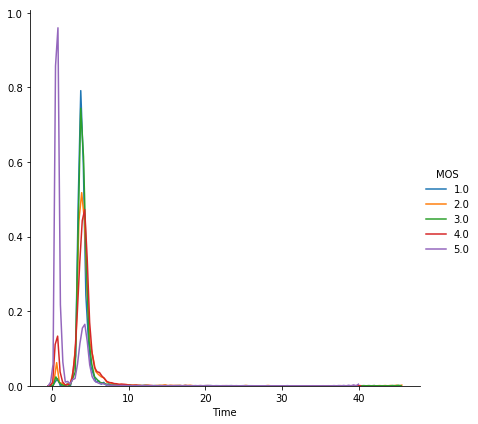

In [55]:
sns.FacetGrid(df,size=6,hue='MOS') \
      .map(sns.kdeplot,"Time") \
      .add_legend();
plt.show();

##### observation: 
From Above PDF we can see that class 5 pdf is clearly separable while other classes PDF are overlaping on each other.

### Signal Feature

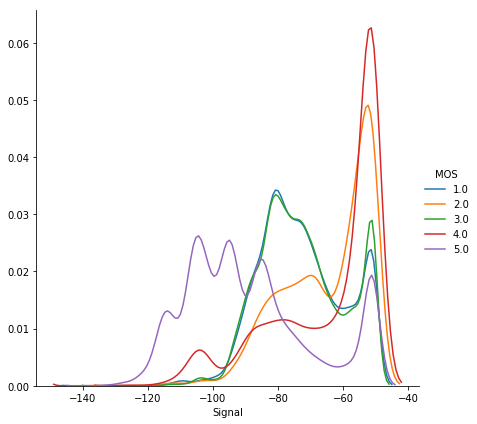

In [56]:
sns.FacetGrid(Analyse_df,size=6,hue='MOS') \
      .map(sns.kdeplot,"Signal") \
      .add_legend();
plt.show();

#### Observaion:  We can see here also PDF of class 5 is separate while PDF of class 1 and class 3 are overlapping while PDF of class 2 and 4 are overlapping

In [8]:
model_df = df.copy()

## Train-test split

In [9]:
Y = model_df['MOS']

In [10]:
model_df.drop(['Date','MOS'],inplace=True,axis=1)

In [11]:
X_train, test_df, y_train, y_test = train_test_split(model_df, Y, stratify=Y, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [12]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 67729
Number of data points in test data: 21166
Number of data points in cross validation data: 16933


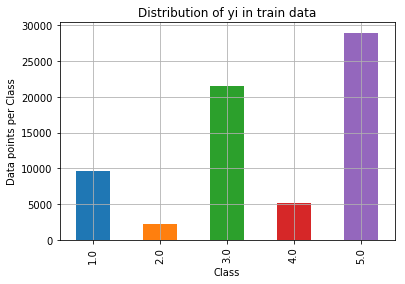

Number of data points in class 5 : 28967 ( 42.769 %)
Number of data points in class 3 : 21585 ( 31.87 %)
Number of data points in class 1 : 9707 ( 14.332 %)
Number of data points in class 4 : 5185 ( 7.656 %)
Number of data points in class 2 : 2285 ( 3.374 %)


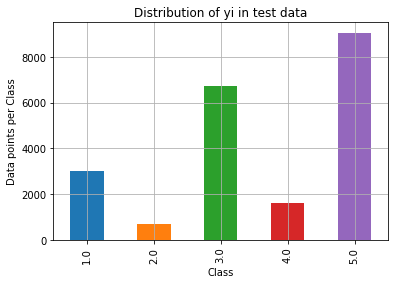

Number of data points in class 5 : 9053 ( 42.771 %)
Number of data points in class 3 : 6745 ( 31.867 %)
Number of data points in class 1 : 3033 ( 14.33 %)
Number of data points in class 4 : 1621 ( 7.659 %)
Number of data points in class 2 : 714 ( 3.373 %)


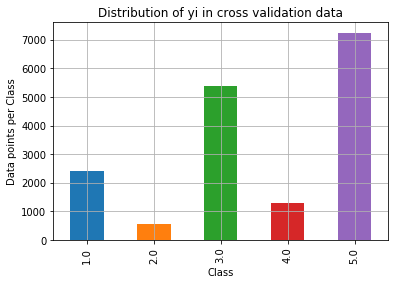

Number of data points in class 5 : 7242 ( 42.769 %)
Number of data points in class 3 : 5396 ( 31.867 %)
Number of data points in class 1 : 2427 ( 14.333 %)
Number of data points in class 4 : 1297 ( 7.66 %)
Number of data points in class 2 : 571 ( 3.372 %)


In [64]:
train_class_distribution = y_train.value_counts().sortlevel()
test_class_distribution = y_test.value_counts().sortlevel()
cv_class_distribution = y_cv.value_counts().sortlevel()


my_colors = 'rgb'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

#Percentage of each class
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')


my_colors = 'rgb'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

    
my_colors = 'rgb'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')




## Performance Matrix Function

In [13]:
def print_metrix(y_tr,y_prd):
    print("Accuracy:",accuracy_score(y_pred=y_prd,y_true=y_tr))
    print("classfication report:",classification_report(y_pred=y_prd,y_true=y_tr))

In [14]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## Feature Engineering

### Feature Encoding

In [15]:
ohe = ce.one_hot.OneHotEncoder(cols=["Result","Type"])
train_df = ohe.fit_transform(train_df)
test_df = ohe.transform(test_df)
cv_df = ohe.transform(cv_df)


In [81]:
#Oversampling
sm = SMOTE(sampling_strategy='minority',random_state=42)
train_df, y_train = sm.fit_resample(train_df, y_train)

In [16]:
# Standardisation
std_encoder = StandardScaler()
train_df = std_encoder.fit_transform(train_df)
test_df = std_encoder.transform(test_df)
cv_df = std_encoder.transform(cv_df)

C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\JAYESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\JAYESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  """


###  Feature 1: PCA

In [83]:
pca.n_components = 2
pca_data_tr = pca.fit_transform(train_df)
pca_data_cv = pca.transform(cv_df)
pca_data_tst= pca.transform(test_df)
# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced_tr.shape = ", pca_data_tr.shape)
print("shape of pca_reduced_cv.shape = ", pca_data_cv.shape)
print("shape of pca_reduced_tst.shape = ", pca_data_tst.shape)

shape of pca_reduced_tr.shape =  (94411, 2)
shape of pca_reduced_cv.shape =  (16933, 2)
shape of pca_reduced_tst.shape =  (21166, 2)


In [84]:
train_df_final = np.column_stack((train_df,pca_data_tr))

test_df_final = np.column_stack((test_df,pca_data_tst))

cv_df_final = np.column_stack((cv_df,pca_data_cv))

### Why PCA useful?

In [85]:
sample_data = train_df

In [86]:
pca.n_components = 2
pca_cmp = pca.fit_transform(sample_data)


In [92]:
new_coordinates = np.column_stack((pca_cmp, y_train))

In [94]:
dataframe = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal", "label"))
print(dataframe.head())

   1st_principal  2nd_principal  label
0       0.991572      -0.154592    5.0
1      -0.139437      -0.172116    3.0
2       2.027068       0.162846    4.0
3       1.607625       0.126217    4.0
4      -3.275948      -0.369900    5.0


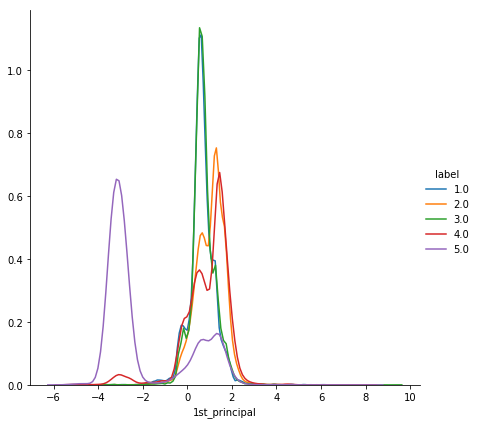

In [95]:
sns.FacetGrid(dataframe,size=6,hue='label') \
      .map(sns.kdeplot,"1st_principal") \
      .add_legend();
plt.show();

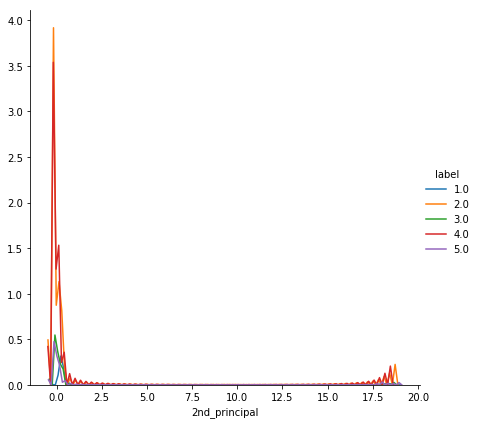

In [96]:
sns.FacetGrid(dataframe,size=6,hue='label') \
      .map(sns.kdeplot,"2nd_principal") \
      .add_legend();
plt.show();

### Observation: As you can see from above 1st principle PDF plots PDF for each class is separable. So PCA features are useful.

##  Feature 2 : K-MEANS clustering

In [98]:
kmeanModel = MiniBatchKMeans(n_clusters=50,batch_size=10000,random_state=42)
kmeanModel.fit(train_df_final)

MiniBatchKMeans(batch_size=10000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=50,
        n_init=3, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [99]:
train_clusters = kmeanModel.predict(train_df_final)

cv_clusters = kmeanModel.predict(cv_df_final)
test_clusters = kmeanModel.predict(test_df_final)

In [100]:
train_df_final = np.column_stack((train_df_final,train_clusters))
cv_df_final = np.column_stack((cv_df_final,cv_clusters))
test_df_final = np.column_stack((test_df_final,test_clusters))

## WHY?

In [101]:
train_clusters_with_label = np.column_stack((train_clusters,y_train))

train_clusters_with_label = pd.DataFrame(train_clusters_with_label,columns=['cluster','label'])

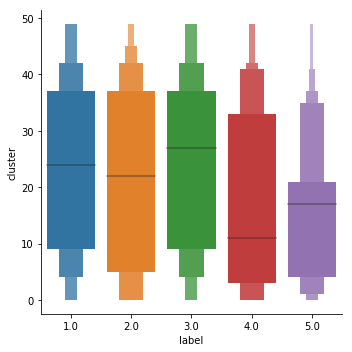

In [102]:
sns.catplot(x='label',y='cluster',kind='boxen',data=train_clusters_with_label)

### Observation: Each class has different distribution for clusters. 

## Hyperparamter tuninf of Ligh GBM model

This is performed on Kaggle environment, so output of cell will not be available.

In [107]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [ ]:
lgbm_hyper_paramgters  = {'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
                         'learning_rate':[100,10,0.1,0.01,0.001]
                         }

In [ ]:
clf = LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)

In [ ]:
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=lgbm_hyper_paramgters, 
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
gs.fit(train_df_final, y_train)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))
print(gs.best_estimator_)

### Optimised LGBM model

In [20]:
lgbm = LGBMClassifier(boosting_type='gbdt', 
               colsample_bytree=0.7160783663472557, importance_type='split',
               learning_rate=0.01, max_depth=-1, metric='None',
               min_child_samples=142, min_child_weight=1e-05,
               min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_leaves=37,
               objective=None, random_state=314, reg_alpha=2, reg_lambda=0.1,
               silent=True, subsample=0.4193485704059235,
               subsample_for_bin=200000, subsample_freq=0)

In [21]:
lgbm = lgbm.fit(train_df,y_train)

Accuracy: 0.7005244259661722
classfication report:               precision    recall  f1-score   support

         1.0       0.39      0.09      0.14      3033
         2.0       0.62      0.16      0.25       714
         3.0       0.53      0.86      0.65      6745
         4.0       0.36      0.23      0.28      1621
         5.0       0.87      0.80      0.83      9053

   micro avg       0.65      0.65      0.65     21166
   macro avg       0.55      0.43      0.43     21166
weighted avg       0.64      0.65      0.61     21166

-------------------- Confusion matrix --------------------


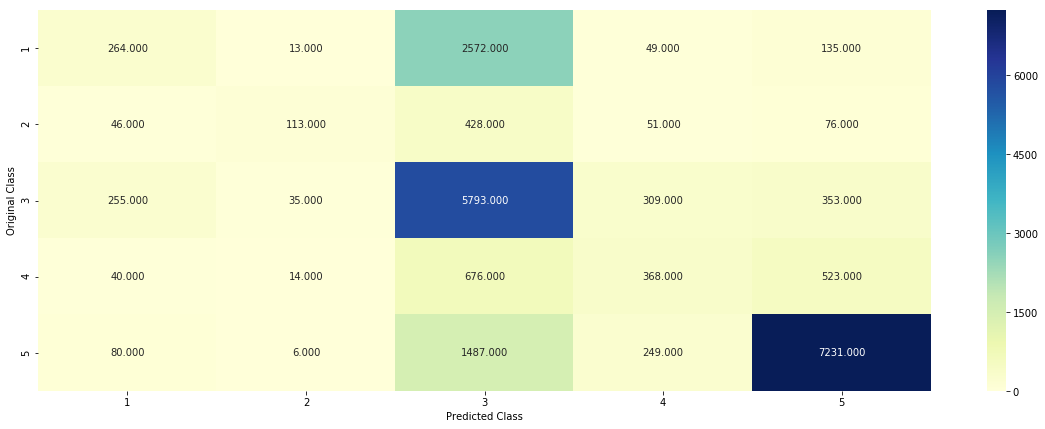

-------------------- Precision matrix (Columm Sum=1) --------------------


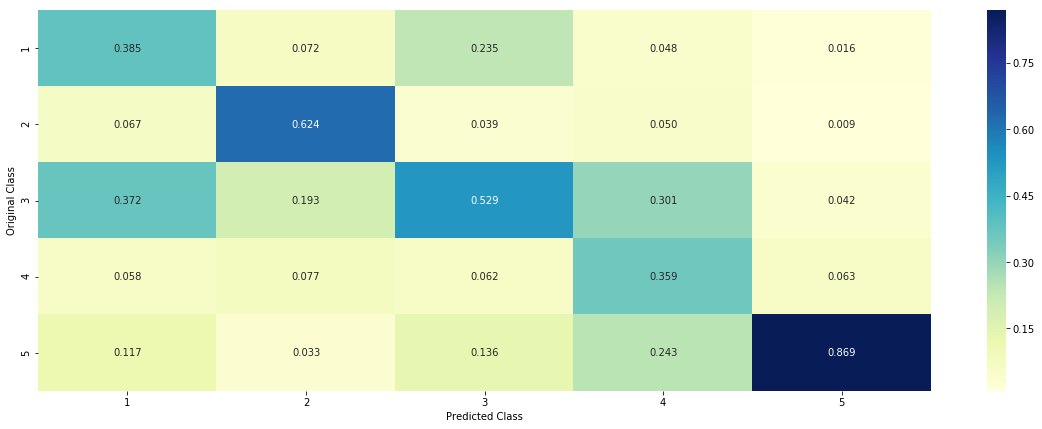

-------------------- Recall matrix (Row sum=1) --------------------


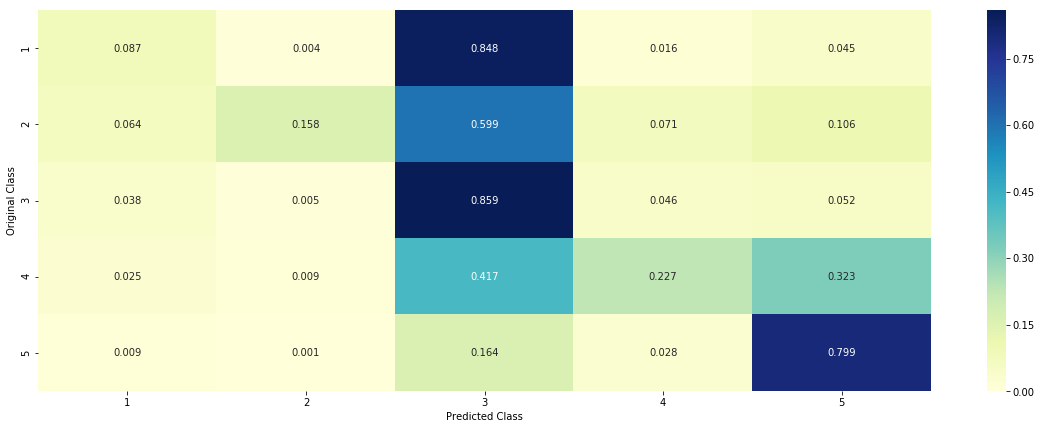

In [22]:
prd_lgbm = lgbm.predict(test_df)
prd_lgbm_train = lgbm.predict(train_df)
print_metrix(y_test,prd_lgbm)
plot_confusion_matrix(y_test, prd_lgbm)

### Logostic regression

Accuracy: 0.5827742606066333
classfication report:               precision    recall  f1-score   support

         1.0       0.29      0.01      0.03      3033
         2.0       0.12      0.59      0.20       714
         3.0       0.55      0.77      0.64      6745
         4.0       0.20      0.19      0.19      1621
         5.0       0.98      0.71      0.82      9053

   micro avg       0.58      0.58      0.58     21166
   macro avg       0.43      0.45      0.38     21166
weighted avg       0.66      0.58      0.58     21166

-------------------- Confusion matrix --------------------


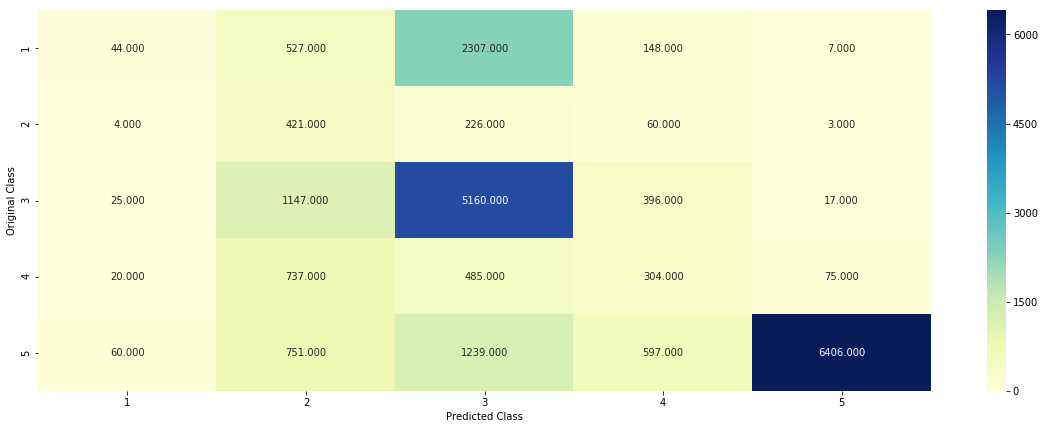

-------------------- Precision matrix (Columm Sum=1) --------------------


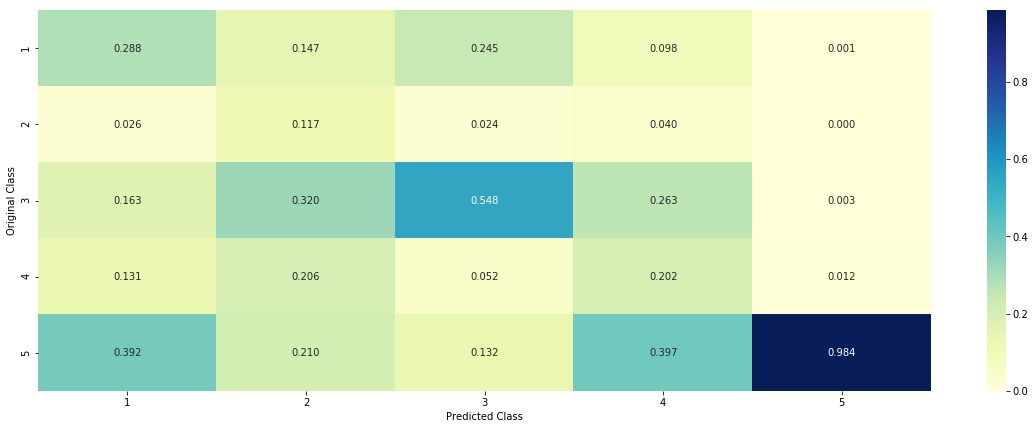

-------------------- Recall matrix (Row sum=1) --------------------


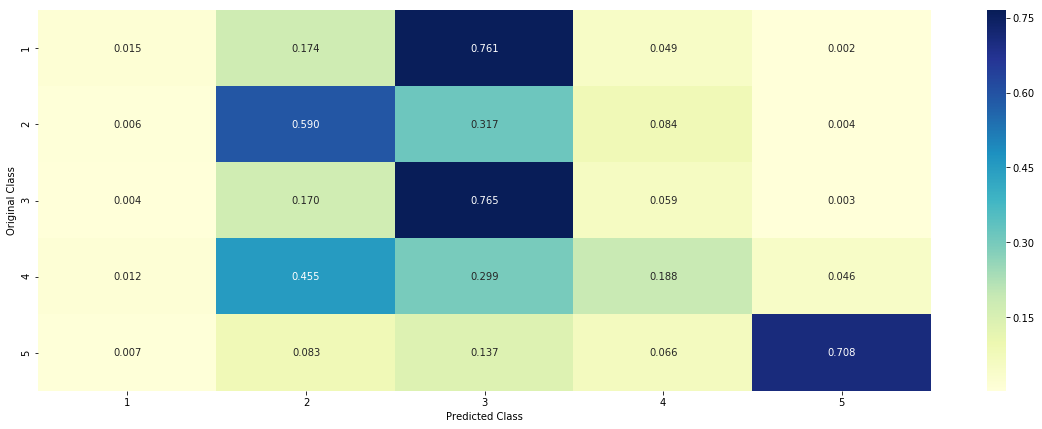

In [116]:
lr_model = LogisticRegression(multi_class='ovr',class_weight='balanced')
lr_model = lr_model.fit(train_df_final,y_train)
prd_mlp_test = lr_model.predict(test_df_final)
prd_mlp_train = lr_model.predict(train_df_final)
print_metrix(y_test,prd_mlp_test)
plot_confusion_matrix(y_test, prd_mlp_test)

## Random Forest

Accuracy: 0.5746007748275537
classfication report:               precision    recall  f1-score   support

         1.0       0.29      0.25      0.27      3033
         2.0       0.12      0.37      0.19       714
         3.0       0.53      0.56      0.55      6745
         4.0       0.30      0.19      0.23      1621
         5.0       0.85      0.78      0.81      9053

   micro avg       0.57      0.57      0.57     21166
   macro avg       0.42      0.43      0.41     21166
weighted avg       0.60      0.57      0.58     21166

-------------------- Confusion matrix --------------------


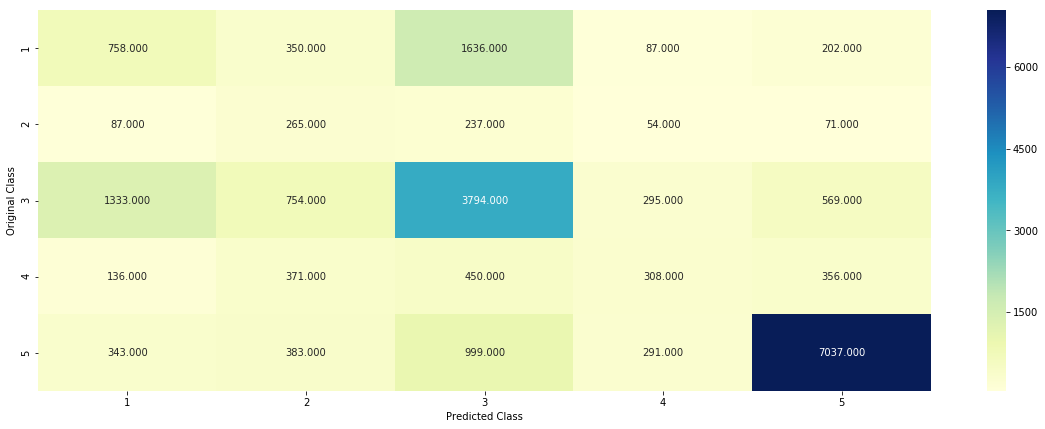

-------------------- Precision matrix (Columm Sum=1) --------------------


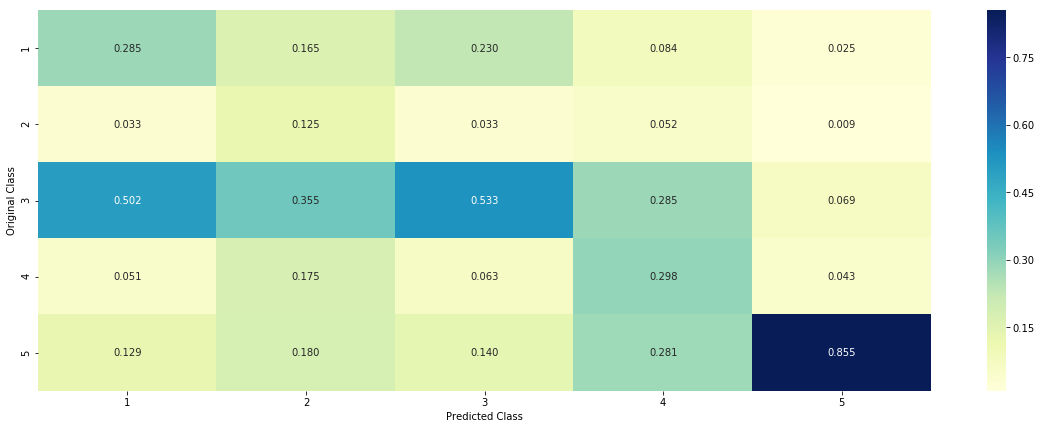

-------------------- Recall matrix (Row sum=1) --------------------


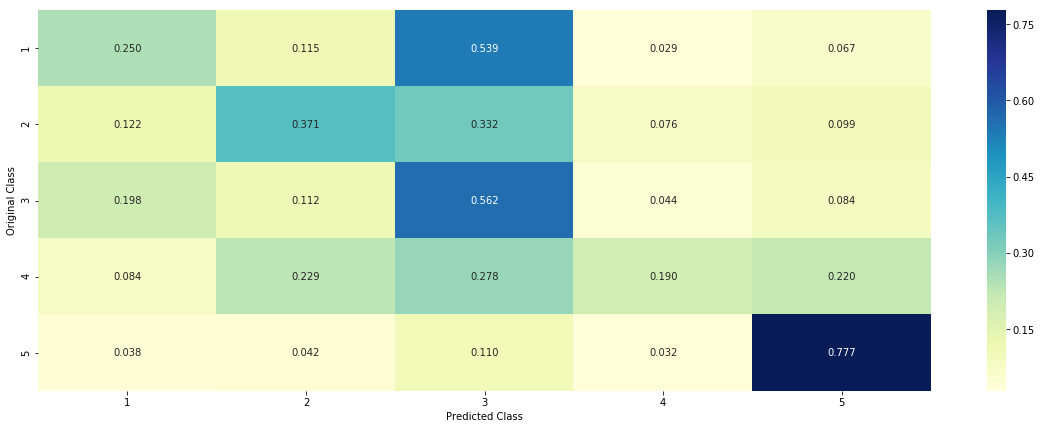

In [118]:
rf = RandomForestClassifier(class_weight='balanced')
rf = rf.fit(train_df_final,y_train)
prd_rf_test = rf.predict(test_df_final)
prd_rf_train = rf.predict(train_df_final)
print_metrix(y_test,prd_rf_test)
plot_confusion_matrix(y_test, prd_rf_test)

## End Notes:

    1. Using domain knowledge we can create feature which will impact performance.
    2. Did not use Accuracy to measure performance. 70% Accuracy as asked in email is achievable.